# Rppg 신호측정

In [1]:
import cv2

from scipy import signal
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import glob
import natsort
import csv

In [3]:
def create_skin_mask(img):
    mask = None
    # 얼굴영역 검출 (피부픽셀 검출)
    try:
        low = np.array([0, 133, 77], np.uint8)
        high = np.array([235, 173, 127], np.uint8)
        
        # 얼굴 box를 찾은 후에 피부픽셀만 분리하는 함수 (실시간성을 고려하지 않으면 다른 모델로 대체 가능)
        ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        mask = cv2.inRange(ycrcb, low, high)
        mask[mask == 255] = 1
    except Exception:
        pass

    return mask

def detrend_signal(arr, win_size):
    # 신호 후처리 함수 (detrend = 추세 를 없앤다.)
    #심박과 관련없는 저주파 와 같은 추세를 없애는 것
    try:
        if arr.ndim == 1:
            arr = np.expand_dims(arr, axis=0)
        n_channel = arr.shape[0]
        norm = signal.convolve2d(np.ones_like(arr), np.ones((n_channel, win_size)), mode='same')
        mean = signal.convolve2d(arr, np.ones((n_channel, win_size)), mode='same') / norm
        return (arr - mean) / (mean + 1e-15)
    except ValueError:
        return arr

def filter_bandpass(arr, srate, band):
    #대역통과필터
    try:
        # 심박수(bpm)의 주파수 도메인은 HZ , 따라서 60을 곱해야 초당이 아닌 분당으로 계산
        nyq = 60 * srate / 2
        coef_vector = signal.butter(5, [band[0] / nyq, band[1] / nyq], 'bandpass')
        return signal.filtfilt(*coef_vector, arr)
    except ValueError:
        return arr
    
def estimate_average_pulserate(arr, srate):
    # 후처리가 완료된 데이터로ㅓ 맥박수 측정
    f, pxx = signal.periodogram(arr, fs=srate, window='hann')
    # 가장 쎈 대역? 주파수 를 찾는다. >> 분당으로 환산한것이 pulserate
    max_peak_idx = np.argmax(pxx)
    pulserate = int(f[max_peak_idx] * 60)
    return min(max(pulserate, band[0]), band[1])

In [6]:
band = [42, 240]
fps = 30

r_signal = []
g_signal = []
b_signal = []
prev_bbox = [0,0,10,10]
curr_bbox = [0,0,10,10]
track_toler = 1
detect_th=0.5
# 얼굴검출 opencv 사용 
detector = cv2.dnn.readNetFromTensorflow('model/face_detector.pb',
                                         'model/face_detector.pbtxt')

times=[]
group=[]

#cap = cv2.VideoCapture(1) # 0: 내장캠 1: 외부캠
#time.sleep(2)

subject=0
file_path="D:\\prlab\\ysg\\rppg\\RPPG-HRV_analysis\\images\\"+str(subject)
file_list=glob.glob(os.path.join(file_path,"*.png"))
file_list = natsort.natsorted(file_list,reverse=False)

try:
    for file in file_list:
        # group 설정
        g=file.split('\\')[-1].split('_')[1]
        group.append(g)
        # time 설정
        t=file.split('\\')[-1].split('_')[-1][:-4]
        times.append(t)
        # 프레임(img) 가져오기
        print("img path: ",file)
        frame = cv2.imread(file, cv2.IMREAD_COLOR)

        # 현재 프레임에서 얼굴 검출하기
        blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), [104., 117., 123.], False, False)
        detector.setInput(blob)
        detections = detector.forward()
        print(detections.shape)

        h, w = frame.shape[:2]
        bboxes = [detections[0, 0, i, 3:7] for i in range(detections.shape[2]) if detections[0, 0, i, 2] >= detect_th]
        if len(bboxes) > 0:
            # bbox가 존재한다면!
            bboxes = sorted(bboxes, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]), reverse=True)
            bboxes = [(rect * np.array([w, h, w, h])).astype('int') for rect in bboxes]  # (xs,ys,xe,ye)
            curr_bbox = bboxes[0] # 얼굴 위치
            prev_bbox = curr_bbox
        else:
            # 존재하지 않는다면 즉, 얼굴 검출이 잘 안됐다면
            curr_bbox = prev_box

        # 얼굴 영역만 잘라내기
        face = frame[curr_bbox[1]:curr_bbox[3], curr_bbox[0]:curr_bbox[2]]

        # remote-PPG 신호 추출하기
        b, g, r = cv2.split(face)
        r_mean = np.mean(r)
        g_mean = np.mean(g)
        b_mean = np.mean(b)
        # 각신호를 담을 list
        r_signal.append(r_mean)
        g_signal.append(g_mean)
        b_signal.append(b_mean)

        # 얼굴 검출 시각화하기
        cv2.rectangle(frame, (curr_bbox[0], curr_bbox[1]), (curr_bbox[2], curr_bbox[3]), (0,0,255), 2)
        cv2.imshow('frame', frame)
        if cv2.waitKey(1) == 27:
            break
            
    
finally:
    cv2.destroyAllWindows()
     print("==================================================!!!finish!!!=================================================")

plt.figure(figsize=(12, 8))
plt.subplot(3,1,1)
plt.plot(r_signal, 'r', linewidth=2)
plt.subplot(3,1,2)
plt.plot(g_signal, 'g', linewidth=2)
plt.subplot(3,1,3)
plt.plot(b_signal, 'b', linewidth=2)
plt.show()

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_0_1_0.0.png
(1, 1, 200, 7)
[210 157 314 307]
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_0_2_33.33329999446869.png
(1, 1, 200, 7)
[210 157 314 307]
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_0_3_66.66669994592667.png
(1, 1, 200, 7)
[210 157 314 307]
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_0_4_100.0.png
(1, 1, 200, 7)
[210 157 315 307]
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_0_5_133.3332999944687.png
(1, 1, 200, 7)
[210 157 315 307]
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_0_6_166.66669994592667.png
(1, 1, 200, 7)
[210 157 314 307]
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_0_7_200.0.png
(1, 1, 200, 7)
[210 157 315 307]
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_0_8_233.3332999944687.png
(1, 1, 200, 7)
[210 157 315 307]
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_0_9_266

(1, 1, 200, 7)
[210 157 315 307]
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_2_71_2333.3332999944687.png
(1, 1, 200, 7)
[210 157 315 307]
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_2_72_2366.6666999459267.png
==================================================!!!finish!!!=================================================


KeyboardInterrupt: 

## 피부영역검출(얼굴제외)

In [38]:
frame = cv2.imread("./WIN_20210722_16_40_08_Pro.jpg", cv2.IMREAD_COLOR)
ycbcr_frame=cv2.cvtColor(frame,cv2.COLOR_BGR2YCR_CB)
lower = np.array([0,150,50], dtype="uint8")
upper = np.array([255,173,127], dtype="uint8")
skin_img = cv2.inRange(ycbcr_frame, lower, upper)
print(skin_img.shape)
img_hand=skin_img
print(img_hand)
for i in range(skin_img.shape[0]):
    for j in range(skin_img.shape[1]):
        if img_hand[i][j]==255:
            if 550<=j<=750 and 0<=i<=350 :
                img_hand[i][j]=0
                print("i,j",img_hand[i][j])
                
cv2.rectangle(img_hand, (750,350), (550, 180), (255,0,0), 2)
cv2.imshow('img',img_hand)
cv2.imshow('skinimg',skin_img)
while True :
    if cv2.waitKey(0) == 27 :
        cv2.destroyWindow('img')
        cv2.destroyWindow('skinimg')
        break;

(720, 1280)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 

i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 

i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 

i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 

i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 

i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 

i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 

i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 

i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 

i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 

i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 

i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 

i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 

i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 

i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 0
i,j 

pulse length:  (19801,)


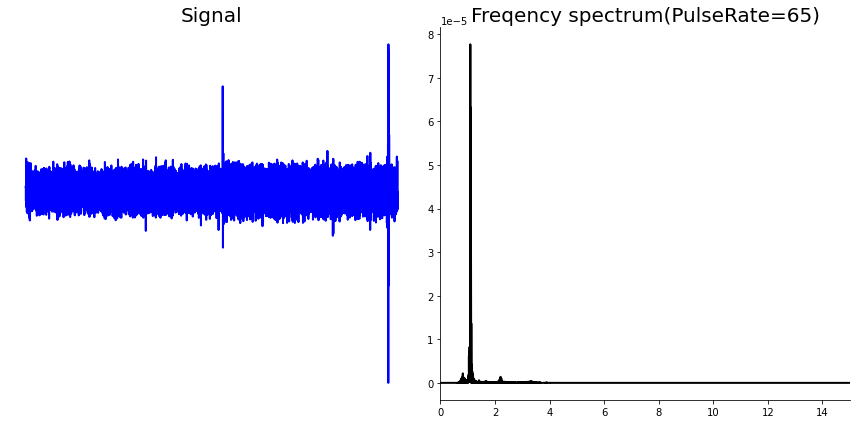

In [5]:
# CHROM 신호 추출
# chrom이란 움직임에 더 강인하게 하는것.
# 움직임은 r,g,b동일하게발생/ pulse는 r,g,b각각 다름
# 이를 이용해 움직임은 제거하고 pulse만 남기도록.

#보통 신호는 g,r,b순으로 잘보인다. 
# 심박수를 더 잘보이게 하기위한 후처리
raw_signal = np.array([r_signal, g_signal, b_signal]).transpose() # 1.세개의 신호를 하나로, 하나의신호화
detrended = detrend_signal(raw_signal, fps) # 2.추세제거
detrended = detrended.transpose()
# 3. 2차원으로 prediction  , 수식에 대해서는 자세히 이해 x
X = 3 * detrended[0] - 2 * detrended[1] # 4. detrend [] > 0: r, 1: g, 2: b
Y = 1.5 * detrended[0] + detrended[1] - 1.5 * detrended[2]
# 5. bandpass filtering
Xf = filter_bandpass(X, fps, band)
Yf = filter_bandpass(Y, fps, band)
alpha = np.std(Xf) / np.std(Yf)
# 6. pulse 신호로 계산
pulse = Xf - alpha * Yf
print("pulse length: ",pulse.shape)

# 심박수 (심장) / '맥박수' (혈관) >> 우리는 맥박수를 보는것.
# 맥박수 계산하는 방법
# 1) 시계열 도메인에서 PPI(peak-to-peak interval) 계산  ==> instant pulse-rate
# 2) 주파수 도메인에서 maximum power band 검출 ==> average pulse-rate


# 주파수 스펙트럼 계산
# 실시간에서는 실시간 fs를 계산해서 파라미터로 넣어줘야함
f, psd = signal.periodogram(pulse, fs=30, window='hann')
max_band = np.argmax(psd)
pr = int(f[max_band] * 60) #분당맥박수
pr = min(max(pr, band[0]), band[1])


plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(pulse, 'b', linewidth=2)    
plt.axis('off')
plt.title('Signal', fontsize=20)

ax = plt.subplot(1,2,2)
plt.plot(f, psd, 'k', linewidth=2)    
plt.xlim([0, 15])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Freqency spectrum(PulseRate={})'.format(pr), fontsize=20)

plt.tight_layout()
plt.show()

file_num=subject
save_path='D:\\prlab\\ysg\\rppg\\rppg_HRV\\data\\rppg\\'
f = open(save_path+'rppg'+str(file_num)+'.csv', 'w', newline='')
wr = csv.writer(f)
wr.writerow(pulse)
wr.writerow(times)
wr.writerow(group)
f.close()

In [11]:
print(pulse.shape)


(253,)
